# Mirror Descent for Robust Regression

Aim is to minimize $$f(x)=\frac{1}{m}\|Ax-b\|_{1}=\frac{1}{m}\sum_{i=1}^{m}|a_{i}^{T}x-b_{i}|$$ subject to $$x\in\mathcal{X}=\{x\in\mathbb{R}_{+}^{n}|\mathbf{1}^{T}x=1\}.$$ Subgradient of the objective is $$\partial f(x)=\frac{1}{m}\sum_{i=1}^{m}\text{sign}(a_{i}^{T}x-b_{i})a_{i}.$$ Mirror descent update $(h(x)=\sum_{i=1}^{n}x_{i}\log x_{i})$: $$x_{i}^{k+1} = \frac{x_{i}^{(k)}\exp(-\alpha g_{i}^{(k)})}{\sum_{j=1}^{n}x_{j}^{(k)}\exp(-\alpha g_{j}^{(k)})}$$

Robust regression problem with $a_{i}\sim N(0,I_{n\times n})$ and $b_{i}=(a_{i,1}+a_{i,2})/2+\epsilon_{i}$ where $\epsilon_{i}\sim N(0,10^{-2})$, $m=50$, $n=100$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from tqdm import tqdm
from scipy.optimize import linprog

### Generate Data

In [2]:
def gen_data(n=100, m=50):

    A = np.random.normal(0, 1, (n,m))
    eps = np.random.normal(0, 1e-2, n)
    b = ((A[:,0]+A[:,1])/2 + eps).reshape(-1,1)
    x0 = (np.ones(m)/m).reshape(-1,1)

    return A, b, x0

In [3]:
A0, b0, x00 = gen_data()
print(A0.shape, b0.shape, x00.shape)
print((A0 @ x00 - b0).shape)

(100, 50) (100, 1) (50, 1)
(100, 1)


In [4]:
def objective(A, b, x):
    x = x.reshape(-1,1)
    return (1/len(x)) * np.linalg.norm(A @ x - b, ord=1)

This is the subgradient

In [5]:
def subgrad(A, b, x):
    x = x.reshape(-1,1)
    return (1/len(x))*(A.T @ np.sign(A @ x - b)).reshape(-1)

### Projected Gradient Descent

In [8]:
def pgd(A, b, x, epsilon=None, T=None):

    assert not (epsilon is None and T is None)

    m = len(x)

    # L is calculated using the (2,2) norm of A, which is maybe not quite right
    # (I guess it should be the (infty,2) norm of A.T, or the (2,1) norm of A).
    # ||nabla f||2 = 1/m*||A.T sign(...)||_2 ~~= 1/m*||A.T||_{2,2}*||sign(...)||_2 ~~= ||A.T||_{2,2}
    L = np.sqrt(np.linalg.eigvals(A.T @ A)[0])
    R = 1

    if epsilon is not None:
        T = (R*L/epsilon)**2
        alpha = (R/L)*np.sqrt(1/T)
        T = round(T)
        print(f"PGD: T={T}, alpha={alpha}")
    else:
        alpha = (R/L)*np.sqrt(1/T)

    # Initialise values and results matrix
    x_gd = np.zeros((m, T))
    x_gd[:,0] = np.ones(m)/m
    losses = []

    # Function that projects onto the simplex
    def project_onto_simplex(v):
        n = len(v)
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u) - 1
        rho = np.nonzero(u > (cssv / np.arange(1, n+1)))[-1][-1]
        theta = cssv[rho] / (rho + 1)
        return np.maximum(v - theta, 0)

    # Iterate over T-1 steps
    for i in range(T-1):

        # Mirror descent update equation
        yi = x_gd[:,i] - alpha * subgrad(A, b, x_gd[:,i])
        x_gd[:,i+1] = project_onto_simplex(yi)

        #losses.append(np.linalg.norm((A @ x_gd[:,i+1] - b), ord=1))

    return x_gd

### Mirror Descent

In [9]:
def mda(A, b, x, epsilon=None, T=None):

    assert not(epsilon is None and T is None)

    m = len(x)
    
    # Values used in the learning rate
    L = 1/m*np.max(np.sum(np.abs(A), axis=0)) # Lipschitz constant in this case is given by the max column sum of absolute values of A. This is the same as np.linalg.norm(A, ord=1)
    #L = np.linalg.eigvals(A.T @ A)[0] 
    R = np.sqrt(np.log(m)) # R is sqrt(log m)
    rho = 1 # 1-strong convexity due to 1 strong convexity of negative entropy

    if epsilon is not None:
        T = (R*L/epsilon)**2*2/rho
        alpha = ((R/L) * np.sqrt(2*rho / T)) # Learning rate formula from Bubeck book page 300
        T = round(T)
        print(f"MDA: T={T}, alpha={alpha}")
    else:
        alpha = ((R/L) * np.sqrt(2*rho / T))

    # Initialise values and results matrix
    x_md = np.zeros((m, T))
    x_md[:,0] = np.ones(m)/m

    # Iterate over T-1 steps
    for i in range(T-1):

        # Mirror descent update equation
        g = subgrad(A, b, x_md[:,i])
        yi = x_md[:,i] * np.exp(-alpha * g)
        x_md[:,i+1] = yi / np.sum(yi)
    
        #losses.append(np.linalg.norm((A @ x_md[:,i+1] - b), ord=1))

    return x_md

### Results

In [18]:
ms = np.logspace(2, 2.5, 5).astype(int)

pgds = []
mds = []
ops = []
f_stars_m = []
f_stars_p = []

eps_pgd = 0.1
eps_mda = 0.1
T = 10000

T_fixed = True

for m in ms:

    A, b, x0 = gen_data(2*m, m) # try n = 2m (or 10m or whatever)

    #ops.append(objective(A, b, robust_regression_l1(A, b)))
    
    if not T_fixed:
        t1 = perf_counter()
        pgds.append(objective(A, b, np.mean(pgd(A, b, x0, epsilon=eps_pgd), axis=1))) # Average all x_ts
        t2 = perf_counter()
        print(f"Time for PGD at m={m}: {t2-t1}")
        mds.append(objective(A, b, np.mean(mda(A, b, x0, epsilon=eps_mda), axis=1))) # Average all x_ts
        t3 = perf_counter()
        print(f"Time for MDA at m={m}: {t3-t2}")
    else:
        pgds.append(objective(A, b, np.mean(pgd(A, b, x0, T=T), axis=1))) # Average all x_ts
        mds.append(objective(A, b, np.mean(mda(A, b, x0, T=T), axis=1))) # Average all x_ts

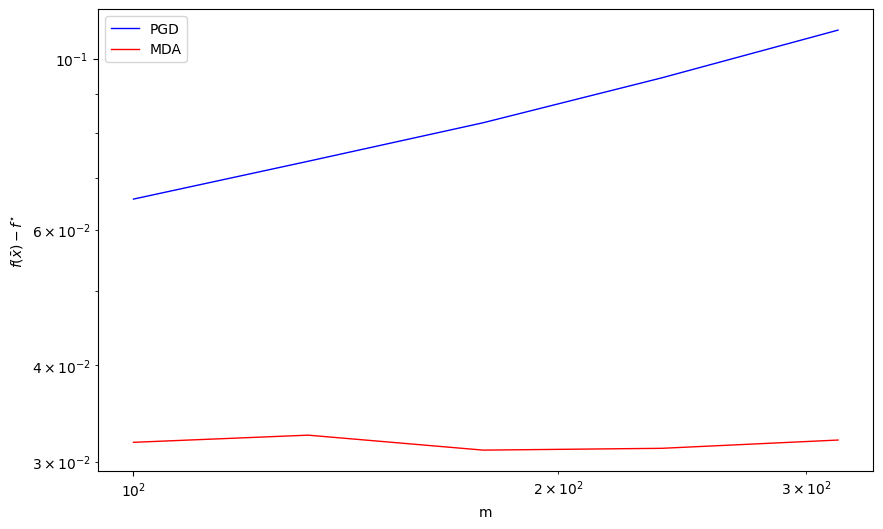

In [22]:
if T_fixed:
    pgd_label = f"PGD"
    mda_label = f"MDA"
else:
    pgd_label = f"PGD ($\epsilon={eps_pgd:.2f}$)"
    mda_label = f"MDA ($\epsilon={eps_mda:.2f}$)"
plt.plot(ms, np.array(pgds), label=pgd_label, color="blue", lw=1, linestyle="solid")
plt.plot(ms, np.array(mds), label=mda_label, color="red", lw=1, linestyle="solid")
#plt.plot(ms, np.array(ops), label="Optimal", color="green", lw=1, linestyle="solid")

plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-5, 1e3)

plt.ylabel(r"$f(\bar{x})-f^{\star}$")
plt.xlabel("m")

plt.legend()
plt.rcParams["figure.figsize"] = (10, 6)
plt.savefig("robust_regression.png", dpi=300)
